In [86]:
import pandas as pd
import jax.numpy as jnp
import jax
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando o dataset wine diretamente do scikit-learn
from sklearn.datasets import load_wine
data, target = load_wine(return_X_y=True, as_frame=True)

eval_dict = {
    'Accuracy' : accuracy_score,
    'MC Coef' : matthews_corrcoef,
    'Confusion Matrix' : confusion_matrix,
    'F1 Score' : f1_score,
    'Recall' : recall_score,
}

print(data.shape)

data.head()

(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [140]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=166003)

compact_data = (x_train, x_test, y_train, y_test )

jx_train, jx_test, jy_train, jy_test = jnp.array(x_train), jnp.array(x_test) , jnp.array(y_train), jnp.array(y_test)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((106, 13), (72, 13), (106,), (72,))

Accuracy : 0.8333
MC Coef : 0.7539
F1 Score : 0.8333
Recall : 0.8333


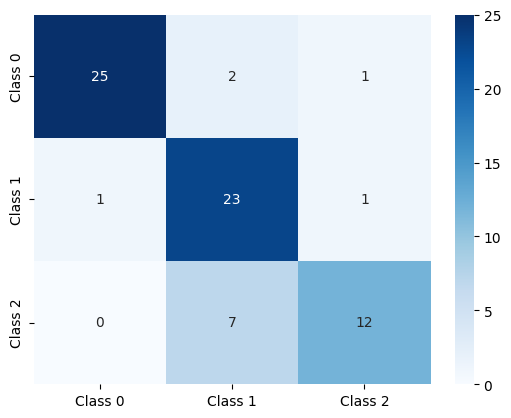

In [156]:
def get_metrics(preds, ytest, eval_metrics):

    results = {}

    for m_name, m_foo in eval_metrics.items():
        if m_name in ['F1 Score', 'Recall'] :
            results[m_name] = m_foo(ytest, preds, average='micro')
        else:
            results[m_name] = m_foo(ytest, preds)

    return results

def show_results(results):
    
    for m_name, m_value in results.items():

        if m_name == 'Confusion Matrix': 

            sns.heatmap(m_value, annot=True, fmt="d", cmap="Blues", cbar=True, 
                xticklabels=["Class 0", "Class 1", "Class 2"], 
                yticklabels=["Class 0", "Class 1", "Class 2"])

        else:
            print(f'{m_name} : {m_value:.4f}')



def run_sklearn_benchmark(data, eval_metrics, k=5, metric='minkowski'): 

    x_train, x_test, y_train, y_test = data

    knn_benchmark = KNeighborsClassifier(n_neighbors=k, metric=metric)

    knn_benchmark.fit(x_train, y_train)

    y_pred = knn_benchmark.predict(x_test)

    results = get_metrics(y_pred, y_test, eval_metrics)


    return results



results = run_sklearn_benchmark(compact_data, eval_dict, k=1)

show_results(results)


In [312]:
X = jnp.array([3, 4])
Y = jnp.array([2, 5])


def general_distance(x, y, inner_product=jnp.dot) :
    # se trocar a funcao jnp.dot, por outro produto interno, isso vira outra metrica de distancia
    A = x - y  
    e = jnp.sqrt(inner_product(A, A))
    print(e.shape)
    return e


# # @jax.jit
def euclidean_distance(x, y):
    # according to sklearn this is faster 
    # return jnp.sqrt(jnp.dot(x,x) - 2 * jnp.dot(x, y.T) + jnp.dot(y,y))
    xy = jnp.dot(x, y.T).sum()
    xx = jnp.dot(x, x.T).sum()
    yy = jnp.dot(y, y.T).sum()

    

    # return jnp.sqrt()


euclidean_distance(X, Y), general_distance(X, Y)





() () ()
()


(None, Array(1.4142135, dtype=float32))

In [323]:
e1 = jnp.sum(jnp.dot(jx_test, jx_test.T))
e2 = jnp.sum(jnp.dot(jx_test.T, jx_test))


(Array(3.1939512e+09, dtype=float32), Array(71298496., dtype=float32))

In [313]:
a = jx_train
b = jx_test
print(a.shape, b.shape)

# diff = a - b 


euclidean_distance(a, b)




(106, 13) (72, 13)
(106, 106) () (72, 72)


In [326]:

import jax.numpy as jnp

def euclidean_distance_with_dot(A, B):
    # Compute the dot product of each row of A with itself (A · A)
    A_dot_A = jnp.sum(A * A, axis=1)
    
    # Compute the dot product of A with B (A · B^T)
    A_dot_B = jnp.dot(A, B.T).flatten()
    
    # Compute the dot product of B with itself (B · B)
    B_dot_B = jnp.sum(B * B)
    
    # Euclidean distance calculation
    distance = jnp.sqrt(A_dot_A - 2 * A_dot_B + B_dot_B)
    
    return distance


euclidean_distance_with_dot(a,b)


TypeError: sub got incompatible shapes for broadcasting: (106,), (7632,).

In [309]:
xx = jnp.dot(a, a.T)
xx.shape

(106, 106)

In [178]:
def fit_knn(xtrain, ytrain, xtest, ytest, dist_f, k = 5):
    
    preds = np.zeros(len(xtest))
    test_samples = {}
    
    for test_inx, test_sample in enumerate(xtest):
        
        test_samples[test_inx] = np.zeros(len(xtrain))
        
        min_dist = float('inf')
                
        for train_inx, train_sample in enumerate(xtrain):
            
            test_samples[test_inx][train_inx] = dist_f(test_sample, train_sample)

        closest_k = ytrain[ np.argsort(test_samples[test_inx])[0:k]]
        preds[test_inx] = np.argmax(np.bincount(closest_k.astype(int)))
   
    return preds#, test_samples




Accuracy : 0.8194
MC Coef : 0.7274
F1 Score : 0.8194
Recall : 0.8194


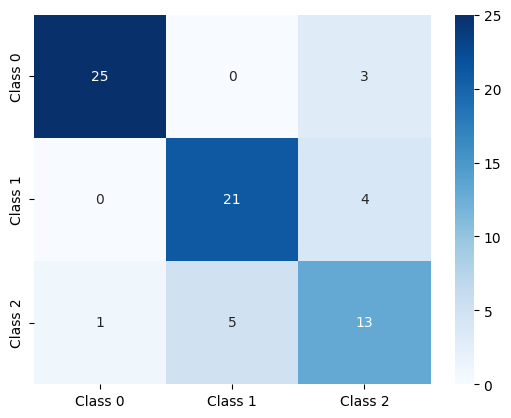

In [180]:
preds = fit_knn(jx_train, jy_train, jx_test, jy_test, euclidean_distance, k=5)


metrics = get_metrics(preds, jy_test, eval_dict)

show_results(metrics)

In [199]:


def fit_knn(xtrain, ytrain, xtest, ytest, dist_f, k = 5):
    
    preds = np.zeros(len(xtest))
    test_samples = {}
    
    for test_inx, test_sample in enumerate(xtest):
        
        test_samples[test_inx] = np.zeros(len(xtrain))
        
        min_dist = float('inf')
                
        for train_inx, train_sample in enumerate(xtrain):
            
            test_samples[test_inx][train_inx] = dist_f(test_sample, train_sample)

        closest_k = ytrain[ np.argsort(test_samples[test_inx])[0:k]]
        preds[test_inx] = np.argmax(np.bincount(closest_k.astype(int)))
   
    return preds#, test_samples


class myKNN():  
    def __init__(self, k, metric) -> None:
        self.k_neighbors = k
        self.metric = metric

    def fit(self, x_train, y_train):
        
        self.X = x_train
        self.y = y_train

        print(self.X.shape)

        return self
    

    def generate_dist(self, x_test):
        print(x_test.shape)
        return self.metric(self.X, x_test)
    
    
    # def predict(self, x_test, y_train):

    #     dist_matrix = jnp.zeros((1,20))#(len(x_test), len(self.X)))

    #     print(dist_matrix.shape,'\n', dist_matrix)

    #     dist_matrix = dist_matrix.at[:,:2].set(3)
    #     print(dist_matrix.shape,'\n', dist_matrix)


# knn_test.predict(jx_test, jy_test)
knn_test = myKNN(5, euclidean_distance)
knn_test.fit(jx_train, jy_train)
knn_test.generate_dist(jx_test)




(106, 13)
(72, 13)


TypeError: dot_general requires contracting dimensions to have the same shape, got (13,) and (106,).